# Определение стоимости автомобилей


Цель проекта: Разработать модель определения рыночной стоимости автомобиля по его характеристикам.   
Заказчик: Сервис по продаже автомобилей с пробегом «Не бит, не крашен»

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import OrdinalEncoder 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

from lightgbm import LGBMRegressor

from sklearn.model_selection import GridSearchCV

import time

from sklearn.dummy import DummyRegressor

### Загрузка и просмотр данных

In [2]:
df = pd.read_csv('Ya_data/autos.csv')
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Признаки:\
DateCrawled — дата скачивания анкеты из базы\
VehicleType — тип автомобильного кузова\
RegistrationYear — год регистрации автомобиля\
Gearbox — тип коробки передач\
Power — мощность (л. с.)\
Model — модель автомобиля\
Kilometer — пробег (км)\
RegistrationMonth — месяц регистрации автомобиля\
FuelType — тип топлива\
Brand — марка автомобиля\
NotRepaired — была машина в ремонте или нет\
DateCreated — дата создания анкеты\
NumberOfPictures — количество фотографий автомобиля\
PostalCode — почтовый индекс владельца анкеты (пользователя)\
LastSeen — дата последней активности пользователя\

### Поиск дубликатов

Проверим на дубликаты

In [4]:
df.duplicated().sum()

4

In [5]:
df.loc[df.duplicated(keep=False)].sort_values(by='Price')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
90964,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
88087,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
41529,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15
187735,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54


Обнаружено 4 дубликата. Удалим дубликаты.

In [6]:
df = df.drop_duplicates()
df.duplicated().sum()

0

<div class="alert alert-block alert-success">
<b>Успех:</b> Данные загружены корректно, первичный осмотр проведен.
</div>

### Поиск пропусков

Поcмотрим относительное количество пропусков в столбцах

In [7]:
df.isna().mean().sort_values() 

DateCrawled          0.000000
Price                0.000000
RegistrationYear     0.000000
Power                0.000000
Kilometer            0.000000
RegistrationMonth    0.000000
Brand                0.000000
DateCreated          0.000000
NumberOfPictures     0.000000
PostalCode           0.000000
LastSeen             0.000000
Model                0.055607
Gearbox              0.055968
FuelType             0.092828
VehicleType          0.105795
NotRepaired          0.200793
dtype: float64

Пропуски NotRepaired возможно небыли выбраны при составлении анкеты. Если не указано наличие ремонта будем считать что его небыло. Заполним пропуски значением yes.

In [8]:
df['NotRepaired'] = df['NotRepaired'].fillna('yes')
df['NotRepaired'].isna().sum()

0

Посмотрим варианты признака VehicleType.

In [9]:
df['VehicleType'].unique()

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

Если тип кузова не указан заменим на вариант other

In [10]:
df['VehicleType'] = df['VehicleType'].fillna('other')
df['VehicleType'].isna().sum()

0

Посмотрим варианты признака FuelType.

In [11]:
df['FuelType'].unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

Если тип топлива не указан заменим на вариант other

In [12]:
df['FuelType'] = df['FuelType'].fillna('other')
df['FuelType'].isna().sum()

0

Посмотрим варианты признака Gearbox.

In [13]:
df['Gearbox'].unique()

array(['manual', 'auto', nan], dtype=object)

Если тип коробки не указан заменим на вариант NA

In [14]:
df['Gearbox'] = df['Gearbox'].fillna('other')
df['Gearbox'].isna().sum()

0

Посмотрим варианты признака Model.

In [15]:
df['Model'].unique()

array(['golf', nan, 'grand', 'fabia', '3er', '2_reihe', 'other', 'c_max',
       '3_reihe', 'passat', 'navara', 'ka', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'meriva', 'arosa', 'c4', 'civic', 'transporter',
       'punto', 'e_klasse', 'clio', 'kadett', 'kangoo', 'corsa', 'one',
       'fortwo', '1er', 'b_klasse', 'signum', 'astra', 'a8', 'jetta',
       'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'insignia', 'combo',
       'focus', 'tt', 'a6', 'jazz', 'omega', 'slk', '7er', '80', '147',
       '100', 'z_reihe', 'sportage', 'sorento', 'v40', 'ibiza', 'mustang',
       'eos', 'touran', 'getz', 'a3', 'almera', 'megane', 'lupo', 'r19',
       'zafira', 'caddy', 'mondeo', 'cordoba', 'colt', 'impreza',
       'vectra', 'berlingo', 'tiguan', 'i_reihe', 'espace', 'sharan',
       '6_reihe', 'panda', 'up', 'seicento', 'ceed', '5_reihe', 'yeti',
       'octavia', 'mii', 'rx_reihe', '6er', 'modus', 'fox'

Если модель не указана заменим на вариант other

In [16]:
df['Model'] = df['Model'].fillna('other')
df['Model'].isna().sum()

0

Проверим пропуски

In [17]:
df.isna().mean().sort_values() 

DateCrawled          0.0
Price                0.0
VehicleType          0.0
RegistrationYear     0.0
Gearbox              0.0
Power                0.0
Model                0.0
Kilometer            0.0
RegistrationMonth    0.0
FuelType             0.0
Brand                0.0
NotRepaired          0.0
DateCreated          0.0
NumberOfPictures     0.0
PostalCode           0.0
LastSeen             0.0
dtype: float64

### Поиск аномальных значений

Посмотрим на распределение числовах параметров.

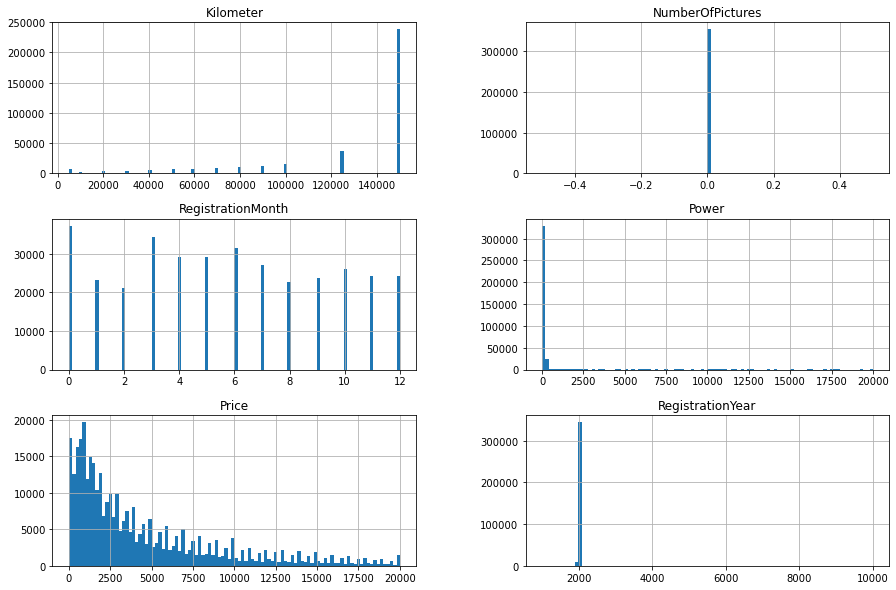

In [18]:
df[{'Price', 'RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth', 'NumberOfPictures'}].hist(bins=100, figsize=(15,10))
plt.show()

In [19]:
df[{'Price', 'RegistrationYear', 'Power', 'Kilometer', 'NumberOfPictures'}].describe()

,Kilometer,NumberOfPictures,Power,Price,RegistrationYear
count,354365.000000,354365.0,354365.000000,354365.000000,354365.000000
mean,128211.363989,0.0,110.093816,4416.679830,2004.234481
std,37905.083858,0.0,189.851330,4514.176349,90.228466
min,5000.000000,0.0,0.000000,0.000000,1000.000000
25%,125000.000000,0.0,69.000000,1050.000000,1999.000000
50%,150000.000000,0.0,105.000000,2700.000000,2003.000000
75%,150000.000000,0.0,143.000000,6400.000000,2008.000000
max,150000.000000,0.0,20000.000000,20000.000000,9999.000000


Распределение признаков Power и RegistrationYear выглядят странно, тут явно присутсвуют выбросы (аномально большие значения).Так же странно выглядят минимальные нулевые значения Power и Price, а так же минимальный RegistrationYear 1000. В NumberOfPictures вечный 0 - бесполезный признак.

Мощность более 500 л.с. и менее 20 л.c. у автомобиоей встречается очень редко. Посмотрим сколько таких данных в %. 

In [20]:
df.query('Power > 500 |  Power < 20')['Power'].count() / len(df) * 100

11.598493079169783

In [21]:
df.query('Power < 1')['Power'].count() / len(df) * 100

11.351290336235238

11% процентов, большинство это нулевые значения.

Аномальные года < 1950 и > 2016. Посмотрим сколько таких данных.

In [22]:
df.query('RegistrationYear > 2016 | RegistrationYear < 1900')['RegistrationYear'].count() / len(df) * 100

4.118916935927645

In [23]:
df = df.drop(df.query('Power > 500 |  Power < 20').index).reset_index(drop=True) # удалим аномально большую мощность
df = df.drop(df.query('RegistrationYear > 2020 | RegistrationYear < 1950').index).reset_index(drop=True) # удалим аномальные года

Посмотрим на измененные признаки

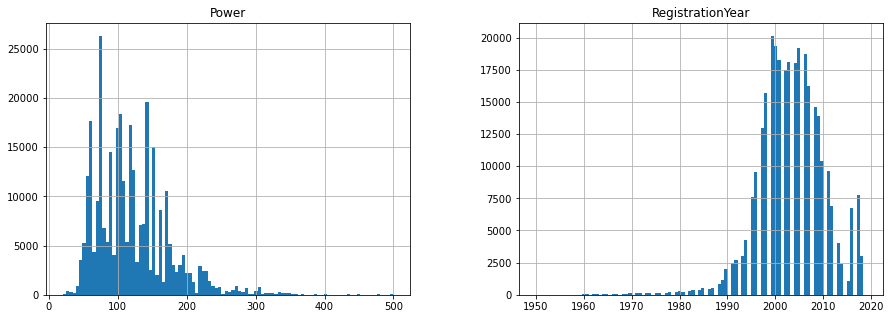

In [24]:
df[{'RegistrationYear', 'Power'}].hist(bins=100, figsize=(15,5))
plt.show()

### Удалим лишние признаки

Признаки DateCrawled и LastSeen, NumberOfPictures, RegistrationMonth никакой информации о цене не предоставляют. Удалим их.

In [25]:
df = df.drop(['DateCrawled', 'LastSeen', 'DateCreated', 'NumberOfPictures', 'RegistrationMonth'], axis = 1)
df

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired,PostalCode
0,18300,coupe,2011,manual,190,other,125000,gasoline,audi,yes,66954
1,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,yes,90480
2,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no,91074
3,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no,60437
4,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes,33775
...,...,...,...,...,...,...,...,...,...,...,...
313190,5250,other,2016,auto,150,159,150000,other,alfa_romeo,no,51371
313191,3200,sedan,2004,manual,225,leon,150000,petrol,seat,yes,96465
313192,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no,26135
313193,9200,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no,87439


### Подготовка признаков

In [26]:
# разобьем данные на 2 части: обучающую и тестовую выборки в соотношнии 4:1
df_train, df_test= train_test_split(df, test_size=0.2, random_state=123)

features_train = df_train.drop(['Price'], axis=1)
target_train = df_train['Price']
features_test = df_test.drop(['Price'], axis=1)
target_test = df_test['Price']

print('Обучающие объекты: признаки {}, цель {}'.format(features_train.shape, target_train.shape))
print('Тестовые объекты: признаки {}, цель {}'.format(features_test.shape, target_test.shape))

Обучающие объекты: признаки (250556, 10), цель (250556,)
Тестовые объекты: признаки (62639, 10), цель (62639,)


Отметим категориальные признаки для модели lightGBM на тренировочной и тестовой выборках.

In [27]:
# изменим тип данных в категориальных признаках на  "category"
numeric = ['RegistrationYear', 'Power', 'Kilometer']
features_train[features_train.columns.drop(numeric)] = features_train[features_train.columns.drop(numeric)].astype('category')
features_train.dtypes

VehicleType         category
RegistrationYear       int64
Gearbox             category
Power                  int64
Model               category
Kilometer              int64
FuelType            category
Brand               category
NotRepaired         category
PostalCode          category
dtype: object

In [28]:
features_test[features_train.columns.drop(numeric)] = features_test[features_train.columns.drop(numeric)].astype('category')
features_test.dtypes

VehicleType         category
RegistrationYear       int64
Gearbox             category
Power                  int64
Model               category
Kilometer              int64
FuelType            category
Brand               category
NotRepaired         category
PostalCode          category
dtype: object

In [29]:
features_train.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired,PostalCode
87034,sedan,2006,manual,180,a6,150000,gasoline,audi,no,30900
71135,wagon,2005,auto,224,a6,150000,gasoline,audi,no,57399
216002,suv,1999,auto,218,m_klasse,150000,lpg,mercedes_benz,no,44894
64268,suv,2006,auto,152,rav,150000,petrol,toyota,no,1157
156850,small,2006,manual,60,c2,125000,petrol,citroen,yes,15366


Для моделей деревьев закодируем категориальные признаки для прямого кодирования (OHE) и категориальные признаки для порядкового кодирования.

In [30]:
ohe = ['NotRepaired', 'Gearbox']
ordinal = ['VehicleType', 'Model', 'Brand','FuelType', 'PostalCode']

features_train_ohe = pd.get_dummies(df_train[ohe], drop_first=True)
features_test_ohe = pd.get_dummies(df_test[ohe], drop_first=True)

encoder = OrdinalEncoder()

features_train_ordinal = pd.DataFrame(encoder.fit_transform(df[ordinal]), columns=df[ordinal].columns)
features_test_ordinal = pd.DataFrame(encoder.fit_transform(df[ordinal]), columns=df[ordinal].columns)

features_train_tree = features_train[numeric].join(features_train_ordinal).join(features_train_ohe)
features_test_tree = features_test[numeric].join(features_test_ordinal).join(features_test_ohe)

In [31]:
features_train_tree.head()

,RegistrationYear,Power,Kilometer,VehicleType,Model,Brand,FuelType,PostalCode,NotRepaired_yes,Gearbox_manual,Gearbox_other
87034,2006,180,150000,4.0,31.0,1.0,2.0,2149.0,0,1,0
71135,2005,224,150000,7.0,31.0,1.0,2.0,4034.0,0,0,0
216002,1999,218,150000,6.0,145.0,20.0,4.0,3123.0,0,0,0
64268,2006,152,150000,6.0,186.0,36.0,6.0,11.0,0,0,0
156850,2006,60,125000,5.0,55.0,5.0,6.0,887.0,1,1,0


Смаштабируем числовые признаки и категориальные признаки порядкового кодирования

In [32]:
#отметим числовые признаки
numeric_skaler = ['RegistrationYear', 'Power', 'Kilometer', 'PostalCode', 'VehicleType', 'Model', 'Brand', 'FuelType']

scaler = StandardScaler()
scaler.fit(features_train_tree[numeric_skaler])
#pd.options.mode.chained_assignment = None #Отключаем предупреждение
features_train_LR = features_train_tree
features_test_LR = features_test_tree
features_train_LR[numeric_skaler] = scaler.transform(features_train_tree[numeric_skaler])
features_test_LR[numeric_skaler] = scaler.transform(features_test_tree[numeric_skaler])


In [33]:
features_train_LR.head()

,RegistrationYear,Power,Kilometer,VehicleType,Model,Brand,FuelType,PostalCode,NotRepaired_yes,Gearbox_manual,Gearbox_other
87034,0.394418,1.119390,0.582723,-0.087007,-1.135053,-1.478426,-1.524515,-0.738625,0,1,0
71135,0.249895,1.942888,0.582723,1.369479,-1.135053,-1.478426,-1.524515,0.193656,0,0,0
216002,-0.617244,1.830593,0.582723,0.883983,0.493756,-0.059340,-0.409008,-0.256905,0,0,0
64268,0.394418,0.595346,0.582723,0.883983,1.079555,1.135679,0.706499,-1.796034,0,0,0
156850,0.394418,-1.126512,-0.098964,0.398488,-0.792146,-1.179671,0.706499,-1.362783,1,1,0


## Обучение моделей

In [34]:
# дипазон параметров для перебора
parametrs_DTR = { 'max_depth': range (10,20),
                  'min_samples_leaf': range (1,6),
                  'min_samples_split': range (2,6,2) }
 
parametrs_RFR = { 'n_estimators': range (5,15,5),
                  'max_depth': range (15,25,2),
                  'min_samples_leaf': range (2,6,2),
                  'min_samples_split': range (2,6,2) }

parametrs_LR = {}

parametrs_LGBMR = {'max_depth': range (1,15,2),
                   'n_estimators': range (5,15,5),
                   'num_leaves': range (2,6,2)}

In [35]:
# подбираем гиперпараметры кроссвалидацией
def model_learn(model_name, param, x, y):
   # warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)
    tic = time.perf_counter()
    model = GridSearchCV(model_name, param, scoring=RMSE_scorer, cv=3, n_jobs=-1)
    model.fit(x, y)
    tac = round(time.perf_counter() - tic, 2)
    print('Время обучения', tac, 'секунд')
    return model, tac

Так как у нас старая версия sklearn в которой нет метрики RMSE сосздадим её из MSE.

In [36]:
def RMSE_score(y_true, y_pred):
    RMSE = mean_squared_error(y_true, y_pred) ** 0.5
    return RMSE

RMSE_scorer = make_scorer(RMSE_score, greater_is_better=False)

In [37]:
# Тест метрики
true = pd.DataFrame([1, -6, 11, 0])
pred = pd.DataFrame([1, -6, 11, 0])
RMSE_score(true, pred)

0.0

Подбираем гиперпараметры для одиночного дерева

In [38]:
%%time
model_DTR = DecisionTreeRegressor(random_state=123)
best_DTR = model_learn(model_DTR, parametrs_DTR, features_train_tree, target_train)
print("Лучшие параметры для DecisionTreeRegressor:", best_DTR[0].best_params_)
print('Лучшая оценка RMSE:',  best_DTR[0].best_score_)

Время обучения 38.13 секунд
Лучшие параметры для DecisionTreeRegressor: {'max_depth': 15, 'min_samples_leaf': 5, 'min_samples_split': 2}
Лучшая оценка RMSE: -1997.9756101159926
Wall time: 38.1 s


Подбираем гиперпараметры для случайного леса

In [39]:
%%time
model_RFR = RandomForestRegressor(random_state=123)
best_RFR = model_learn(model_RFR, parametrs_RFR, features_train_tree, target_train)
print("Лучшие параметры для RandomForestRegressor:", best_RFR[0].best_params_)
print('Лучшая оценка RMSE:',  best_RFR[0].best_score_ )

Время обучения 79.55 секунд
Лучшие параметры для RandomForestRegressor: {'max_depth': 19, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 10}
Лучшая оценка RMSE: -1781.9826377897273
Wall time: 1min 19s


Для линейной регресси нечего подбирать. Тут просто повторяется механизм кросвалидации.

In [40]:
%%time
model_LR = LinearRegression()
best_LR = model_learn(model_LR, parametrs_LR, features_train_LR, target_train)
print("Лучшие параметры для LinearRegression:", best_LR[0].best_params_)
print('Лучшая оценка RMSE:',  best_LR[0].best_score_ )

Время обучения 0.32 секунд
Лучшие параметры для LinearRegression: {}
Лучшая оценка RMSE: -3020.618804892116
Wall time: 322 ms


Подбираем гиперпараметры для градиентного бустинга

In [41]:
%%time
model_LGBMR = LGBMRegressor(random_state=123)
best_LGBMR = model_learn(model_LGBMR, parametrs_LGBMR, features_train, target_train)
print("Лучшие параметры для LGBMRegressor:", best_LGBMR[0].best_params_)
print('Лучшая оценка RMSE:',  best_LGBMR[0].best_score_ )

Время обучения 6.96 секунд
Лучшие параметры для LGBMRegressor: {'max_depth': 3, 'n_estimators': 10, 'num_leaves': 4}
Лучшая оценка RMSE: -3232.1114442590183
Wall time: 6.96 s


### Итоги обучения с подбором параметров 

In [42]:
pd.DataFrame({'Модель': ['Решающее дерево', 'Случайный лес', 'Регрессия', 'Градиентный бустинг'],
               'RMSE' : [best_DTR[0].best_score_, best_RFR[0].best_score_, best_LR[0].best_score_, best_LGBMR[0].best_score_],
              'Время подбора парамтров, сек' : [best_DTR[1], best_RFR[1], best_LR[1], best_LGBMR[1]]})

,Модель,RMSE,"Время подбора парамтров, сек"
0,Решающее дерево,-1997.975610,38.13
1,Случайный лес,-1781.982638,79.55
2,Регрессия,-3020.618805,0.32
3,Градиентный бустинг,-3232.111444,6.96


## Анализ моделей

Проверим модели на тестовой выборке

In [43]:
best_models = [[best_DTR[0].best_estimator_, 'DecisionTreeRegressor', features_train_tree, features_test_tree],
              [best_RFR[0].best_estimator_, 'RandomForestRegressor', features_train_tree, features_test_tree],
              [best_LR[0].best_estimator_, 'LinearRegression', features_train_LR, features_test_LR],
              [best_LGBMR[0].best_estimator_, 'LGBMRegressor', features_train, features_test]]

In [44]:
tuc_fit = []
tac_pred = []
RMSE_test = []
for best_model, model_name, x_train, x_test in best_models:
    toc = time.perf_counter()
    best_model.fit(x_train, target_train)
    tuc = round(time.perf_counter() - toc, 3)
    tic = time.perf_counter()
    predictions_test = best_model.predict(x_test)
    tac = round(time.perf_counter() - tic, 3)
    RMSE = round(RMSE_score(target_test, predictions_test))
    print('RMSE для', model_name, 'на тестовой выборке:', RMSE, 'Время предсказания', tac, 'секунд')
    tuc_fit.append(tuc)
    tac_pred.append(tac)
    RMSE_test.append(RMSE)
    

RMSE для DecisionTreeRegressor на тестовой выборке: 1920 Время предсказания 0.012 секунд
RMSE для RandomForestRegressor на тестовой выборке: 1738 Время предсказания 0.117 секунд
RMSE для LinearRegression на тестовой выборке: 3023 Время предсказания 0.003 секунд
RMSE для LGBMRegressor на тестовой выборке: 3232 Время предсказания 0.021 секунд


Проверим модели на адекватность в сравнении с константной моделью.

In [45]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(features_train, target_train)
predictions_dummy = dummy_regr.predict(features_train)
RMSE = round(RMSE_score(target_train, predictions_dummy))
print("RMSE для константы на обучающей выборке", RMSE)

RMSE для константы на обучающей выборке 4590


In [46]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(features_test, target_test)
predictions_dummy = dummy_regr.predict(features_test)
RMSE = round(RMSE_score(target_test, predictions_dummy))
print("RMSE для константы на тестовой выборке", RMSE)

RMSE для константы на тестовой выборке 4587


Посмотрим важность признаков

<AxesSubplot:title={'center':'Важность признаков'}, ylabel='feature'>

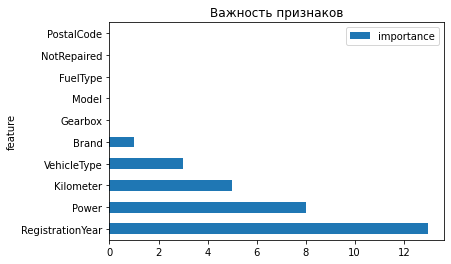

In [47]:
# model is the trained model
importances = best_LGBMR[0].best_estimator_.feature_importances_

# train_features is the dataframe of training features
feature_list = list(features_train.columns)

# Extract the feature importances into a dataframe
feature_results = pd.DataFrame({'feature': feature_list,'importance': importances})

# Show the top most important
feature_results = feature_results.sort_values('importance',ascending = False).reset_index(drop=True)

feature_results.plot(x='feature', y='importance',  kind = 'barh', title='Важность признаков' )

## Вывод

In [48]:
pd.DataFrame({'Модель'       : ['Решающее дерево', 'Случайный лес', 'Регрессия', 'Градиентный бустинг'],
 'RMSE на обучающей выборке' : [abs(best_DTR[0].best_score_), abs(best_RFR[0].best_score_), abs(best_LR[0].best_score_), abs(best_LGBMR[0].best_score_)],
 'RMSE на тестовой выборке'  : RMSE_test,
 'Время подбора, сек'        : [best_DTR[1], best_RFR[1], best_LR[1], best_LGBMR[1]],
 'Время обучения, сек'       : tuc_fit,
 'Время предсказания, сек'   : tac_pred})


,Модель,RMSE на обучающей выборке,RMSE на тестовой выборке,"Время подбора, сек","Время обучения, сек","Время предсказания, сек"
0,Решающее дерево,1997.975610,1920,38.13,0.816,0.012
1,Случайный лес,1781.982638,1738,79.55,6.075,0.117
2,Регрессия,3020.618805,3023,0.32,0.038,0.003
3,Градиентный бустинг,3232.111444,3232,6.96,0.188,0.021


Самая быстрая модель - линейная регрессия. Она значительно быстрее всех моделей и не  требует подбора параметров. По качеству на ~30 % уступает деревиям. Градиентый бустинг показал качество чуть хуже линейнй регрессии, а скорость сопоставимую с деревьями. Все модели прошли проверку на адекватность, показав метрику значитьльно лучше чем константная модель. Из выделенных признаков наибольшую значимость имеют: год регистрации, мощность двигателя, пробег, тип кузова и брэнд. Остальные признаки имеют околонулевую значимость. Их можно удалить несильно потеряв в качестве(<5%),  но сильно увеличив скорость работы(в 3 раза). Исходя из результатов обучения и анализа для данной задачи можно рекомендовать модель Линейной регрессии.

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей